<h1 style="font-size: 3em;">Détection de faux billets: EDA and Preprocessing</h1>

# Introduction

Dans ce notebook, nous développons un modèle de détection de faux billets à partir d'un jeu de données comprenant 1000 vrais billets et 500 faux billets. Après une analyse exploratoire des données et un prétraitement pour les optimiser, nous testerons plusieurs modèles de machine learning afin de sélectionner les plus performants.

L'objectif principal est d'obtenir un modèle capable de détecter les faux billets avec un rappel (recall) d'au moins 99%, tout en maintenant une précision supérieure à 98%. Nous procéderons également à l'optimisation des hyperparamètres et à l'évaluation rigoureuse des modèles avant de les intégrer dans une application de détection fiable.

<h1 style="font-size: 2em;">Sommaire</h1>

- # [Exploratory Data Analysis](#exploratory-data-analysis)
  - ### [1. Préparation](#1-Préparation)
  - ### [2. Analyse de forme](#2-analyse-de-forme)
    - [Conclusion de l'analyse de forme](#conclusions-de-l-analyse-de-forme)
 
  - ### [3. Analyse de fond](#3-analyse-de-fond)
    - [Examen de la variable cible](#examen-de-la-variable-cible)
    - [Examen des variables continues](#examen-des-variables-continues)
    - [Relation cible/Variables](#relation-cible-variables)
    - [Relation Variables/Variables](#relation-variables-variables)
    - [Conclusion de l'analyse de Fond](#conclusions-de-lanalyse-de-forme)

- # [Preprocessing](#preprocessing)
  - ### [1. Régression linéaire pour imputer les NaN](#1-régression-linéaire-pour-imputer-les-nan)
  
  - ### [2. Preprocessing avec suppression des NaN](#2-preprocessing-avec-suppression-des-nan)
  
  - ### [3. Polynomial Transformation and Features Selection](#3-polynomial-transformation-and-features-selection)

- # [Modélisation](#modélisation)
  - ### [1. Modèle d'apprentissage non supervisé - KMeans](#1-modèle-dapprentissage-non-supervisé---kmeans)
    - [Analyse en composante principale](#analyse-en-composante-principale)
    - [Clustering avec KMeans](#clustering-avec-kmeans)
  
  - ### [2. Modèles d'apprentissage supervisés](#2-modèles-dapprentissage-supervisés)
  
  - ### [3. Optimisation des modèles sélectionnés](#3-optimisation-des-modèles-sélectionnés)
    - [Modèle SVM](#modèle-svm)
    - [Modèle de régression logistique](#modèle-de-régression-logistique)
- # [Conclusion](#conclusion)


<h1 style="font-size: 3em;">Exploratory Data Analysis</h1>
<a id="exploratory-data-analysis"></a>



### **Objectifs :**

Comprendre du mieux possible nos données 

Développer une premiere stratégie de modélisation

<h2 style="font-size: 2.5em;">1.Préparation</h2>
<a id="1-préparation"></a>


# Chargement des librairies

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, KFold, learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV

# Machine Learning Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Pipeline
from sklearn.pipeline import make_pipeline

# Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, silhouette_score,
    confusion_matrix, roc_curve, auc, precision_score, recall_score,
    f1_score, classification_report, precision_recall_curve
)
from sklearn.metrics import ConfusionMatrixDisplay

# Statistics & Diagnostic Tests
from scipy import stats
from scipy.stats import kstest, norm
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
import statsmodels.api as sm

# Saving Models
import joblib

# Importation du fichier

In [2]:
data= pd.read_csv('billets.csv', delimiter= ';')

In [3]:
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

<h2 style="font-size: 2.5em;"> 2. Analyse de forme</h2>
<a id="2-analyse-de-forme"></a>

In [4]:
# Copie du dataframe d'origine
df= data.copy()

In [5]:
# Dimensions
df.shape

(1500, 7)

In [6]:
# Info, Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
# Valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

<h3 style="font-size: 2em;">Conclusions de l'analyse de forme</h3>
<a id="conclusions-de-l-analyse-de-forme"></a>

**variable target :** "is_genuine"

**lignes et colonnes :** 1500 lignes, 7 colonnes

**types de variables :** qualitatives : variable cible (bool) , quantitatives : 6 variables

**Analyse des valeurs manquantes :** On dénombre 37 valeurs manquantes dans la variable "margin_low"


<h2 style="font-size: 2.5em;">3. Analyse de fond</h2>
<a id="3-analyse-de-fond"></a>

<h3 style="font-size: 2em;">Examen de la variable cible</h3>
<a id="examen-de-la-variable-cible"></a>


In [8]:
# Proportion des valeurs
df['is_genuine'].value_counts(normalize=True)

is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64

<h3 style="font-size: 2em;">Examen des variables continues</h3>
<a id="examen-des-variables-continues"></a>

In [9]:
# Statistiques
df.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

### Histogramme

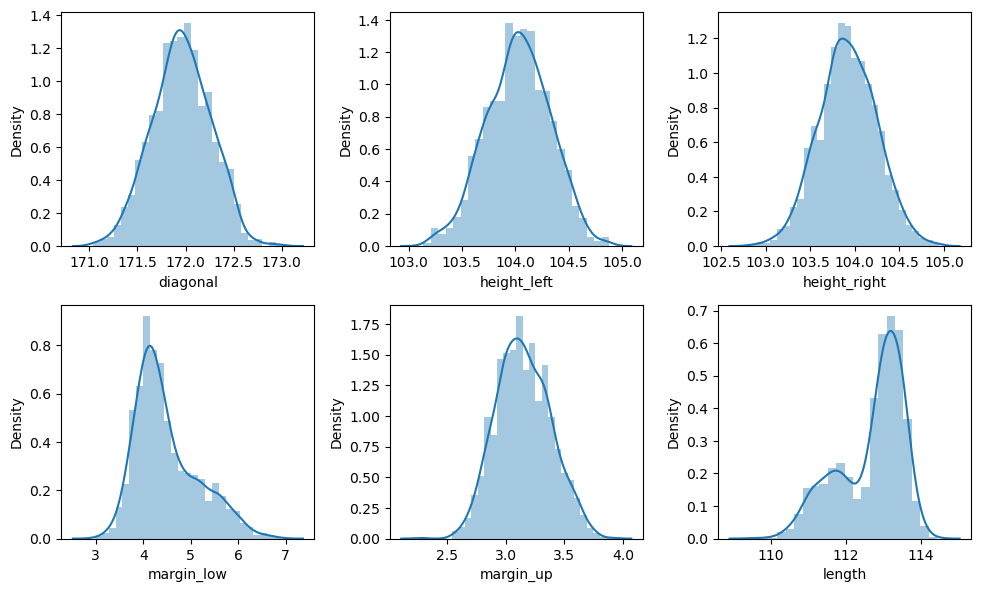

In [10]:
col_var_predict= df.select_dtypes('float').columns
plt.figure(figsize=(10,6))
for i,col in enumerate (col_var_predict) :
    plt.subplot(2,len(col_var_predict)//2,i+1)
    sns.distplot(df[col])
plt.tight_layout()
plt.show()  


### Box-Plot

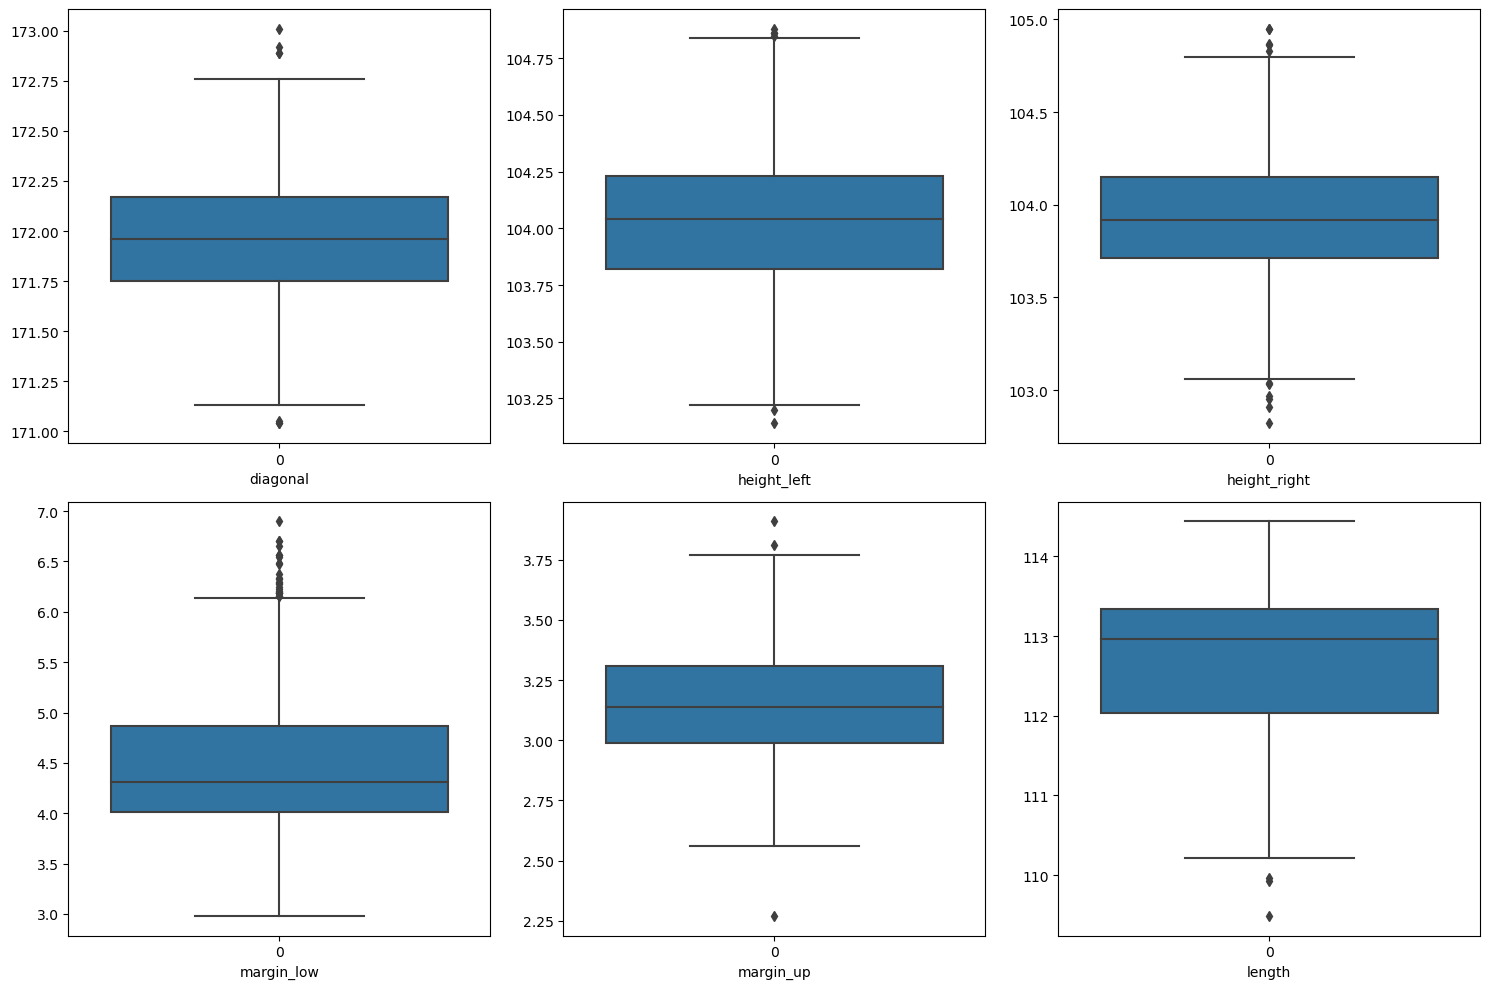

In [11]:
plt.figure(figsize=(15,10))

for i,col in enumerate (col_var_predict) :
    plt.subplot(2,len(col_var_predict)//2,i+1)
    sns.boxplot(df[col])
    
    plt.xlabel(col)
plt.tight_layout()
plt.show()

<h3 style="font-size: 2em;">Relation cible/Variables</h3>
<a id="relation-cible-variables"></a>


In [12]:
# Création de sous-ensembles True et False
df_True= df[df['is_genuine']==True]
df_False= df[df['is_genuine']==False]

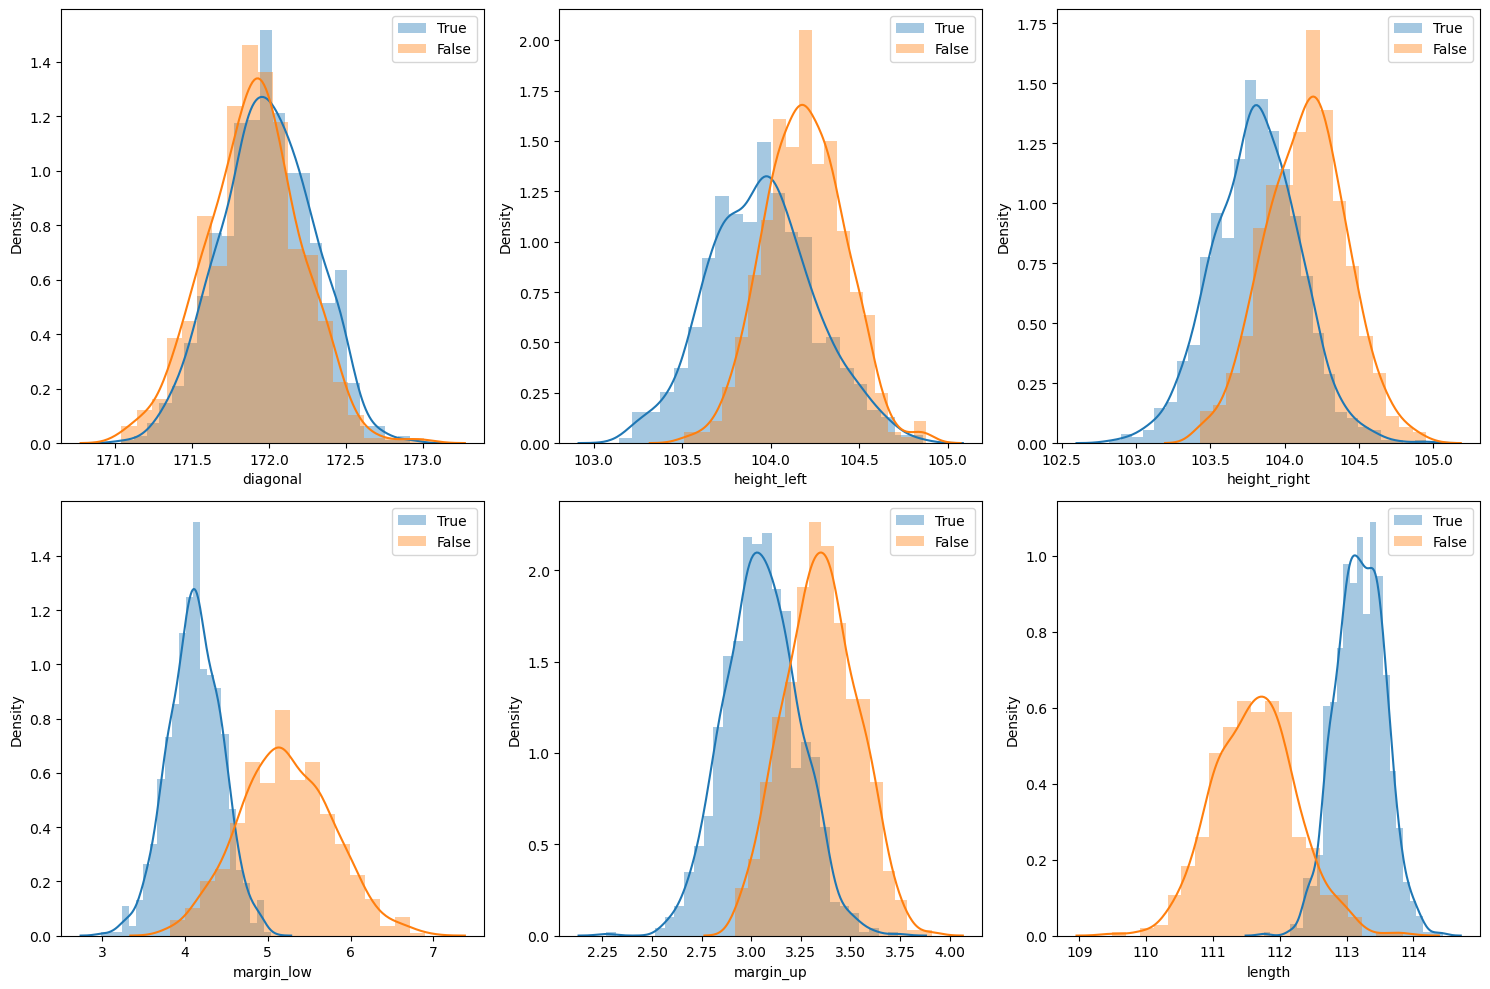

In [13]:
plt.figure(figsize=(15,10))
for i,col in enumerate (col_var_predict) :
    plt.subplot(2,len(col_var_predict)//2,i+1)
    sns.distplot(df_True[col], label= 'True')
    sns.distplot(df_False[col], label= 'False')
    plt.legend()
plt.tight_layout()
plt.show()  

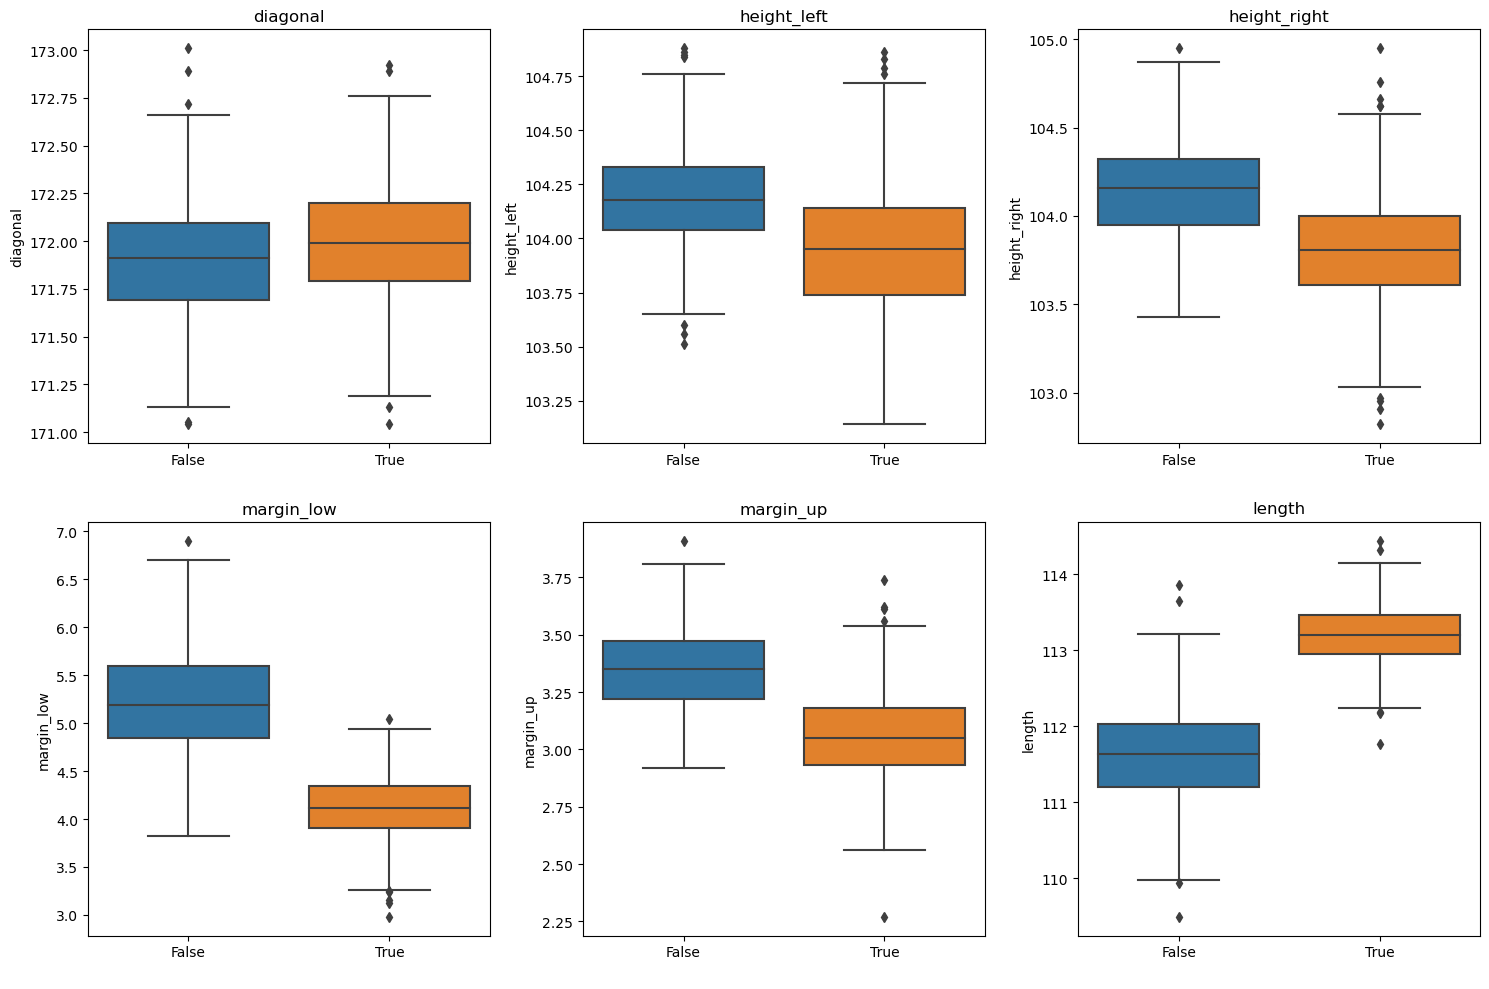

In [14]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(col_var_predict):
    plt.subplot(2, len(col_var_predict) // 2, i + 1)
    sns.boxplot(x='is_genuine', y=col, data=df)
    plt.title(f'{col}')
    plt.xlabel(' ')
plt.tight_layout()
plt.show()

<h3 style="font-size: 2em;">Relation Variables/Variables</h3>
<a id="relation-variables-variables"></a>

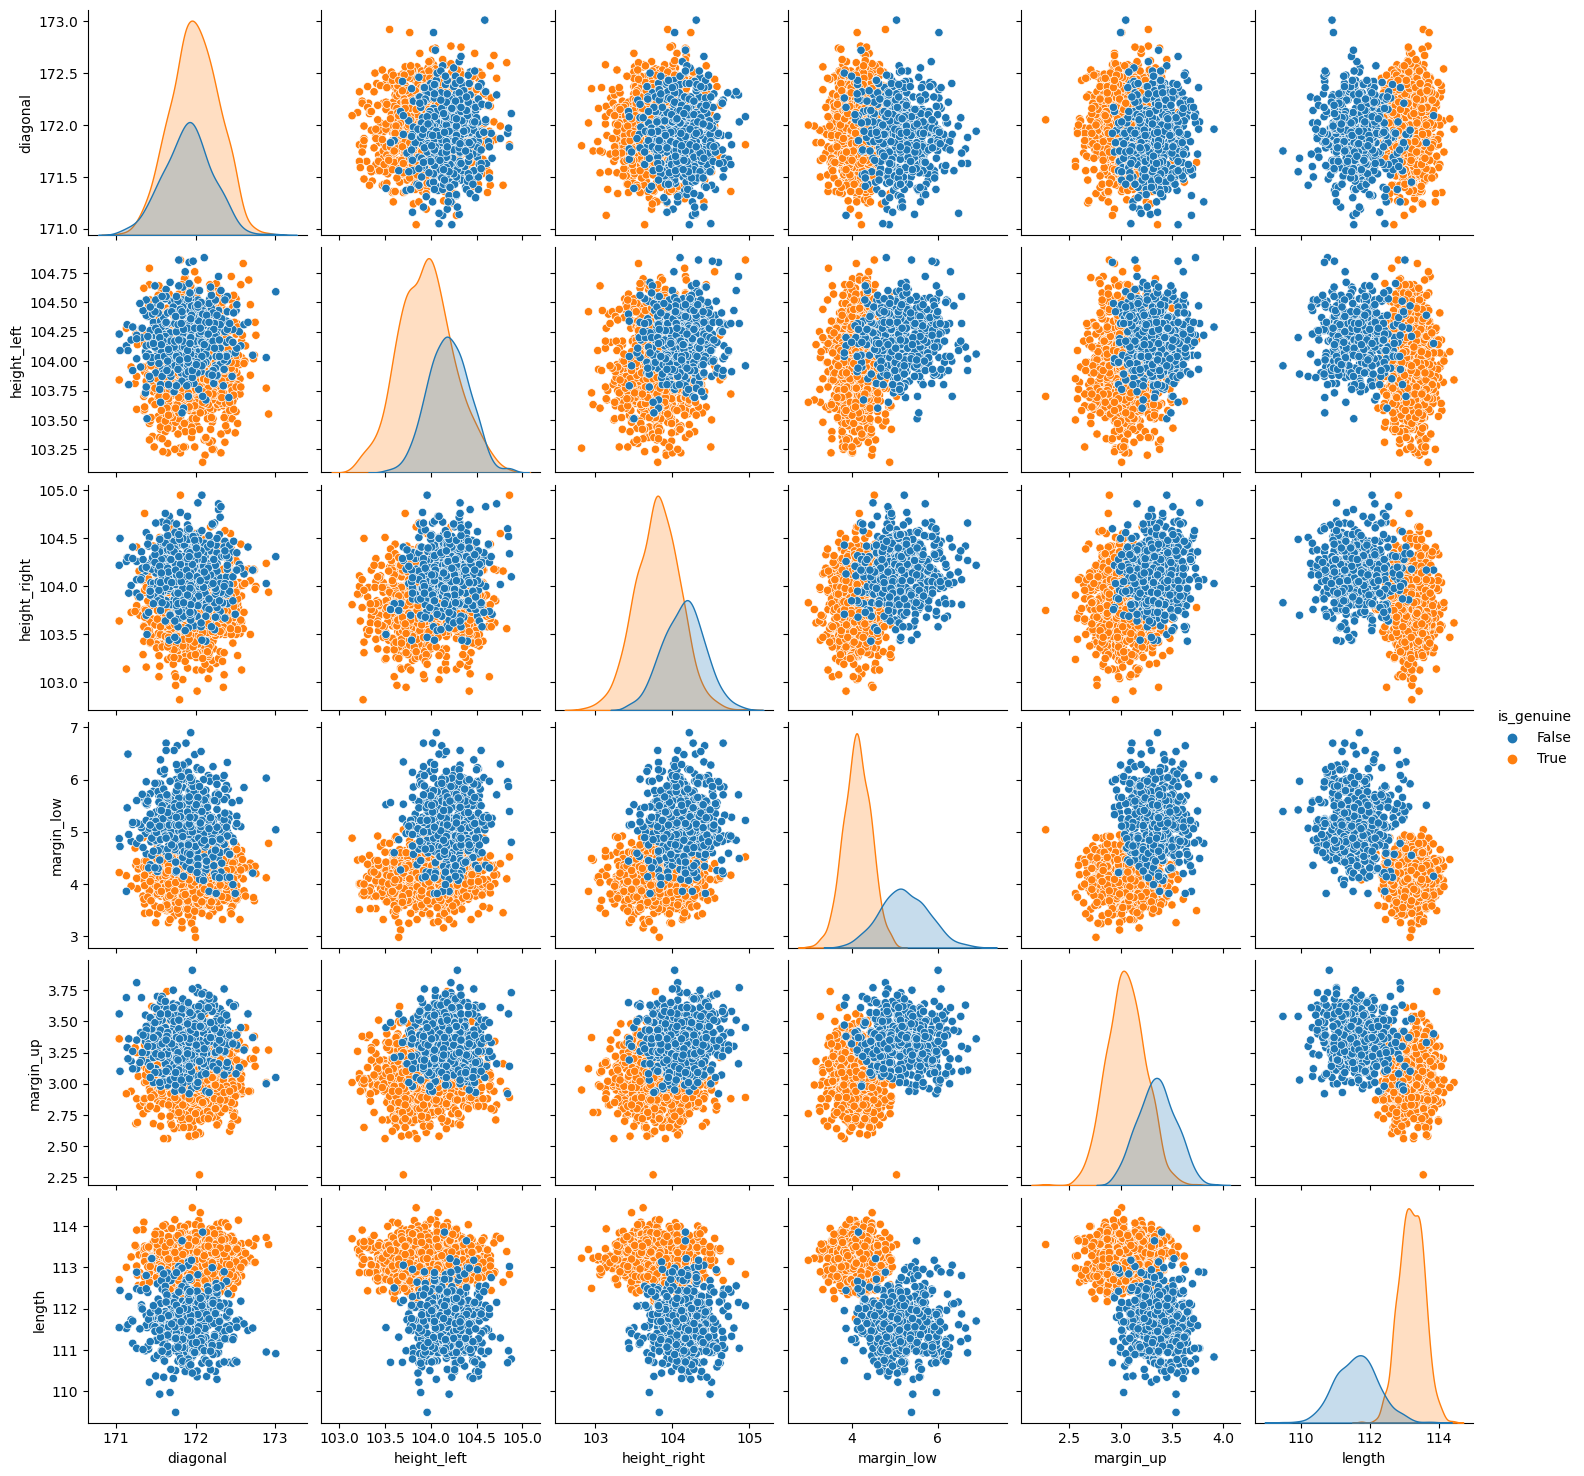

In [15]:
# Visualisation sous forme de pairplot
sns.pairplot(df, hue='is_genuine')

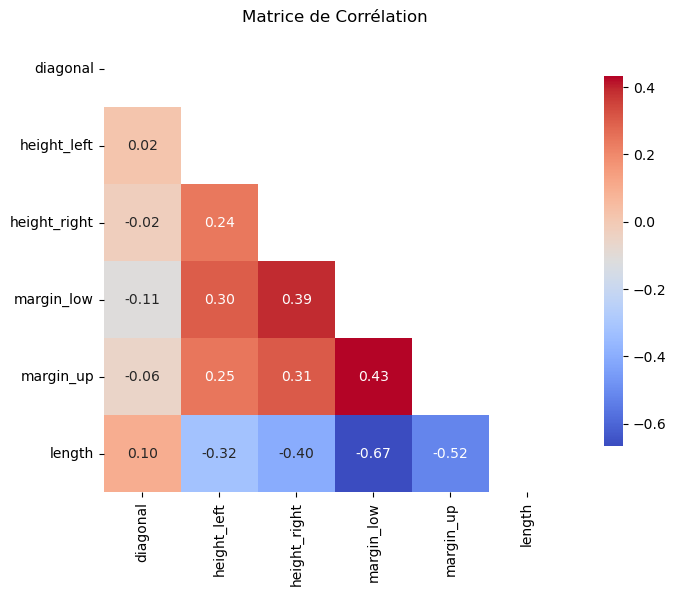

In [16]:
# Affichage de la matrice de corrélation avec un heatmap
correlation_matrix=df[col_var_predict].corr()
# Création d'un masque pour n'afficher que la demi-heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 6))

sns.heatmap(correlation_matrix,mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Matrice de Corrélation')
plt.show()

In [17]:
correlation_matrix

diagonal  height_left  height_right  margin_low  margin_up  \
diagonal      1.000000     0.019472     -0.024492   -0.111534  -0.055649   
height_left   0.019472     1.000000      0.242279    0.302643   0.246522   
height_right -0.024492     0.242279      1.000000    0.391085   0.307005   
margin_low   -0.111534     0.302643      0.391085    1.000000   0.431606   
margin_up    -0.055649     0.246522      0.307005    0.431606   1.000000   
length        0.097587    -0.320863     -0.401751   -0.666753  -0.520575   

                length  
diagonal      0.097587  
height_left  -0.320863  
height_right -0.401751  
margin_low   -0.666753  
margin_up    -0.520575  
length        1.000000

<h3 style="font-size: 2em;">Conclusions de l'analyse de Fond</h3>
<a id="conclusions-de-lanalyse-de-forme"></a>



### **Visualisation de la cible :** 
66% de True, 33% de False

### **Signification des variables:**

**length :** la longueur du billet (en mm) ;

**height_left :** la hauteur du billet (mesurée sur le côté gauche, en
mm) ;

**height_right :** la hauteur du billet (mesurée sur le côté droit, en mm) ;

**margin_up :** la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;

**margin_low :** la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;

**diagonal :** la diagonale du billet (en mm).

### **Relation Cible/Variables**

Mise à part la variable "diagonal", il y a de fortes différences sur toutes les autres variables entre les vrais et faux billets. C'est particulièrement le cas des variables "lenght" et "margin_low."
Ces deux variables sont celles dont les distributions sont les plus éloignées d'une distribution normale.


### **Relation Variables/Variables**

Les relations entre variables ne sont pas linéaires.

Le pairplot des deux variables les plus disciminantes entre vrais et faux billets (lenght et margin_low) permet de distinguer deux groupes de points bien séparés.

On constate que "margin_low" et "margin_up" sont fortement anticorrélées à "lenght".

La variable "diagonal" semble apporter peu d'information en raison de sa faible corrélation avec les autres variables. 

<h1 style="font-size: 3em;">Preprocessing</h1>
<a id="preprocessing"></a>

### **Objectif :** 
Préparer et optimiser les données pour la modélisation

## Séparation du Df en trainset et testset

In [18]:
# Copie du Df d'origine
df = data.copy()
# Séparation du Df en trainset et testset
trainset,testset= train_test_split(df, test_size=0.2, random_state=0)

print(f'Nombre d\'échantillons du trainset: {trainset.shape[0]}')
print(f"proportion de faux billets dans le trainset:{round(trainset['is_genuine'].value_counts(normalize=True)[1],2)}")
print(f'Nombre d\'échantillons du testset: {testset.shape[0]}')
print(f"proportion de faux billets dans le testset:{round(testset['is_genuine'].value_counts(normalize=True)[1],2)}")

Nombre d'échantillons du trainset: 1200
proportion de faux billets dans le trainset:0.34
Nombre d'échantillons du testset: 300
proportion de faux billets dans le testset:0.32


<h2 style="font-size: 2.5em;">1. Régression linéaire pour imputer les NaN</h2>
<a id="1-régression-linéaire-pour-imputer-les-nan"></a>


### Fonction encodage

In [19]:
# Implémentation de la fonction d'encodage
def encodage (df):
    code={False: 0,
         True: 1}
    for col in df.select_dtypes("bool"):
        df[col]=df[col].map(code)
               
    return df
    

### Fonction de scalling

In [20]:
# Implémentation de la fonction de scalling
def standardisation (df):
    scaller = StandardScaler()
    for col in df.select_dtypes("float"):
            df[col]= scaller.fit_transform(df[[col]])
    return df

### Fonction d'imputation par regression avec évaluation et test statistiques

In [21]:
def regression_imputer(df, target_column):
    # Créer deux sous-ensembles de données : avec et sans NaN dans la colonne cible
    non_missing_data = df[df[target_column].notna()]
    missing_data = df[df[target_column].isna()]

    # Séparer les données complètes en ensembles d'entraînement et de validation pour évaluer la régression
    X_train, X_val, y_train, y_val = train_test_split(
        non_missing_data.drop(columns=[target_column, 'is_genuine']),
        non_missing_data[target_column],
        test_size=0.2,
        random_state=0
    )

    # Vérifiez les types de données et convertissez en numérique si nécessaire
    X_train = X_train.apply(pd.to_numeric, errors='coerce')
    X_val = X_val.apply(pd.to_numeric, errors='coerce')

    # Entraîner le modèle de régression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Évaluer le modèle sur l'ensemble de validation
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)

    print(f"Métriques de performance sur l'ensemble de validation :")
    print(f"- Mean Squared Error (MSE) : {mse:.2f}")
    print(f"- Root Mean Squared Error (RMSE) : {rmse:.2f}")
    print(f"- Mean Absolute Error (MAE) : {mae:.2f}")
    print(f"- R^2 Score : {r2:.2f}")

    # Graphiques de dispersion
    print("\nGraphiques de dispersion :")
    for column in X_train.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=X_train[column], y=y_train)
        plt.title(f'Dispersion de {column} vs {target_column}')
        plt.xlabel(column)
        plt.ylabel(target_column)
        plt.show()

    # Test de Rainbow
    X_train_const = sm.add_constant(X_train)
    rainbow_stat, rainbow_p_value = linear_rainbow(OLS(y_train, X_train_const).fit())
    print("\nTest de Rainbow pour la linéarité :")
    print("H0 : Le modèle est correctement spécifié (linéarité)")
    print(f"Statistique : {rainbow_stat:.4f}, p-value : {rainbow_p_value:.4f}")
    if rainbow_p_value < 0.05:
        print("Conclusion : Rejet de H0, le modèle pourrait être mal spécifié (non-linéaire).\n")
    else:
        print("Conclusion : H0 non rejetée, le modèle est probablement linéaire.\n")

    # VIF (Facteur d'inflation de la variance)
    vif = pd.DataFrame()
    vif["features"] = X_train.columns
    vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(vif)

    # Test d'homoscédasticité
    y_train_pred = model.predict(X_train)
    residuals = y_train - y_train_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_train_pred, y=residuals)
    plt.axhline(0, linestyle='--', color='red', linewidth=1)
    plt.title("Test d'homoscédasticité")
    plt.xlabel('Prédictions')
    plt.ylabel('Résidus')
    plt.show()

    # Test de Breusch-Pagan
    bp_test = het_breuschpagan(residuals, X_train_const)
    print("\nTest de Breusch-Pagan pour l'homoscédasticité")
    print("H0 : Les résidus sont homoscédastiques (variance constante)")
    print(f"Statistique : {bp_test[0]:.4f}, p-value : {bp_test[1]:.4f}")
    if bp_test[1] < 0.05:
        print("Conclusion : Rejet de H0, les résidus ne sont pas homoscédastiques.\n")
    else:
        print("Conclusion : H0 non rejetée, les résidus sont homoscédastiques.\n")

    # Vérification de la normalité des résidus avec tests de Shapiro-Wilk et Kolmogorov-Smirnov
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.title("Histogramme des résidus")
    plt.xlabel("Résidus")
    plt.ylabel("Fréquence")
    plt.show()

    plt.figure(figsize=(8, 6))
    sm.qqplot(residuals, line='s')
    plt.title("Diagramme Q-Q des résidus")
    plt.show()

    print("\nTest de Shapiro-Wilk pour la normalité des résidus")
    shapiro_stat, shapiro_p_value = stats.shapiro(residuals)
    print(f"Statistique : {shapiro_stat:.4f}, p-value : {shapiro_p_value:.4f}")
    if shapiro_p_value < 0.05:
        print("Conclusion : Rejet de H0, les résidus ne sont pas normalement distribués.\n")
    else:
        print("Conclusion : H0 non rejetée, les résidus suivent une distribution normale.\n")



    # Test de Kolmogorov-Smirnov pour la normalité des résidus
    ks_stat, ks_p_value = kstest(residuals, 'norm')
    print(f"Statistique : {ks_stat:.4f}, p-value : {ks_p_value:.4f}")
    if ks_p_value < 0.05:
        print("Conclusion : H0 rejetée, les résidus ne suivent pas une distribution normale.\n")
    else:
        print("Conclusion : H0 non rejetée, les résidus suivent une distribution normale.\n")


    # Imputer les valeurs manquantes
    missing_data[target_column] = model.predict(missing_data.drop(columns=[target_column, 'is_genuine']))
    df_imputed = pd.concat([non_missing_data, missing_data]).sort_index()

    return df_imputed


### Fonction de preprocessing et d'imputation par régression

In [22]:
def preprocessing_regression_imputer(df, target_column):
    # Étape 1: Encodage
    df = encodage(df)
    
    # Étape 2: Standardisation
    df = standardisation(df)
    
    # Étape 3: Entraînement du modèle et imputation des valeurs manquantes sur l'ensemble d'entraînement
    df = regression_imputer(df, target_column)
    
    
    # Séparer les caractéristiques et la variable cible
    X = df.drop('is_genuine', axis=1)
    y = df['is_genuine']
    
    print(y.value_counts())
    return X, y

Métriques de performance sur l'ensemble de validation :
- Mean Squared Error (MSE) : 0.54
- Root Mean Squared Error (RMSE) : 0.73
- Mean Absolute Error (MAE) : 0.57
- R^2 Score : 0.46

Graphiques de dispersion :


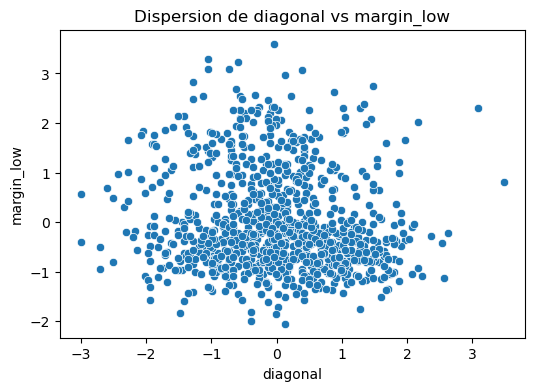

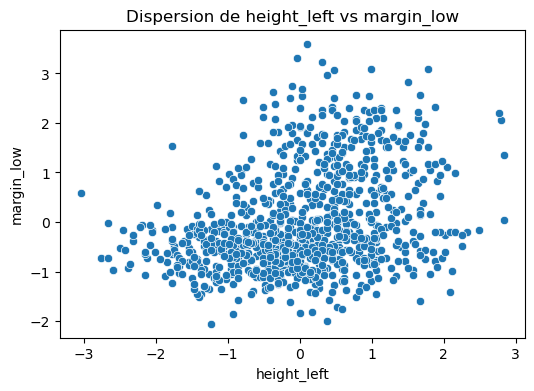

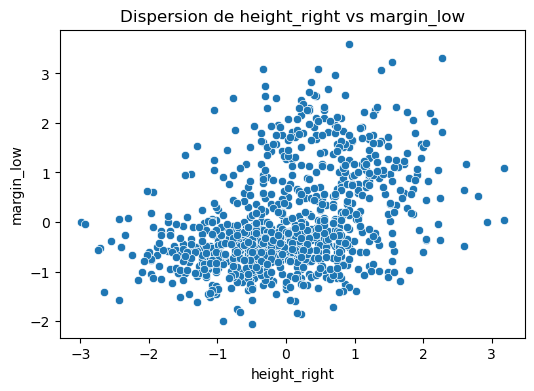

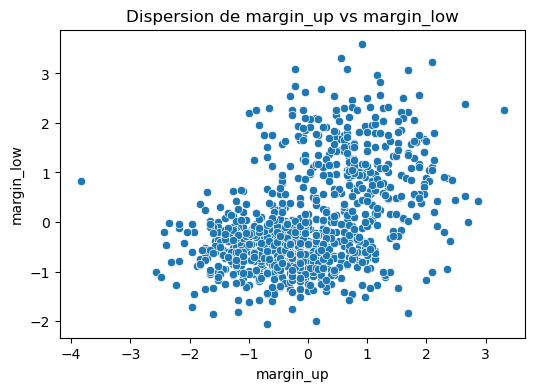

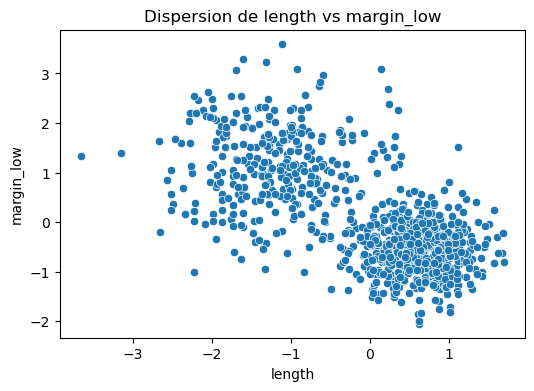


Test de Rainbow pour la linéarité :
H0 : Le modèle est correctement spécifié (linéarité)
Statistique : 1.0196, p-value : 0.4175
Conclusion : H0 non rejetée, le modèle est probablement linéaire.

       features  VIF Factor
0      diagonal    1.011842
1   height_left    1.144458
2  height_right    1.232456
3     margin_up    1.390407
4        length    1.579884


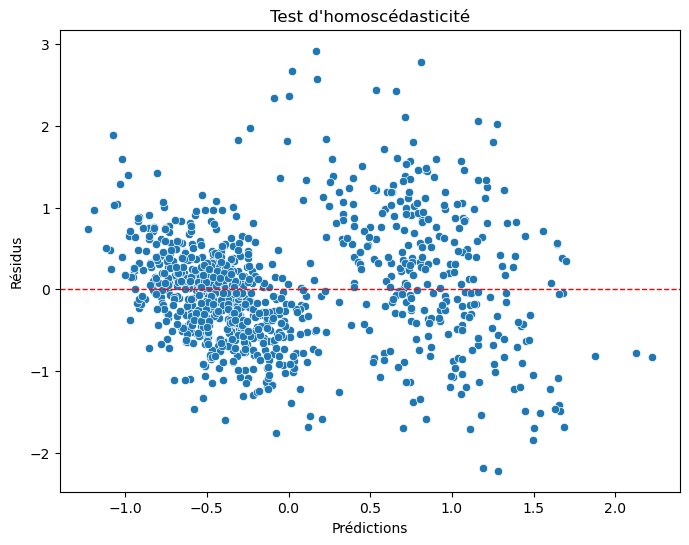


Test de Breusch-Pagan pour l'homoscédasticité
H0 : Les résidus sont homoscédastiques (variance constante)
Statistique : 67.9485, p-value : 0.0000
Conclusion : Rejet de H0, les résidus ne sont pas homoscédastiques.



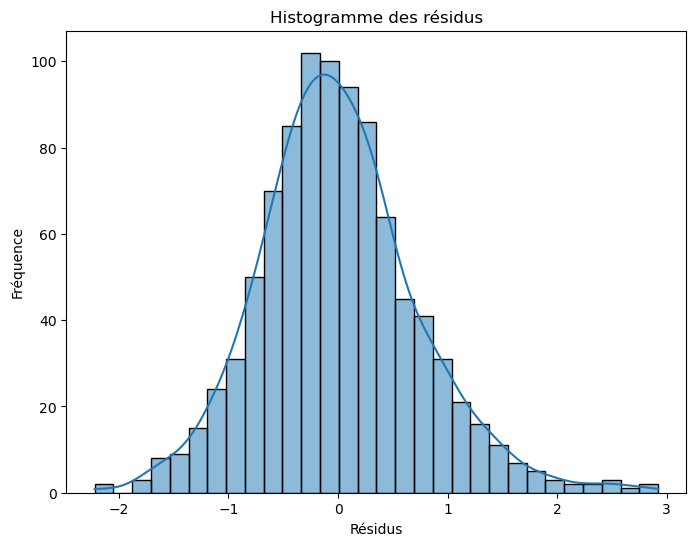

<Figure size 800x600 with 0 Axes>

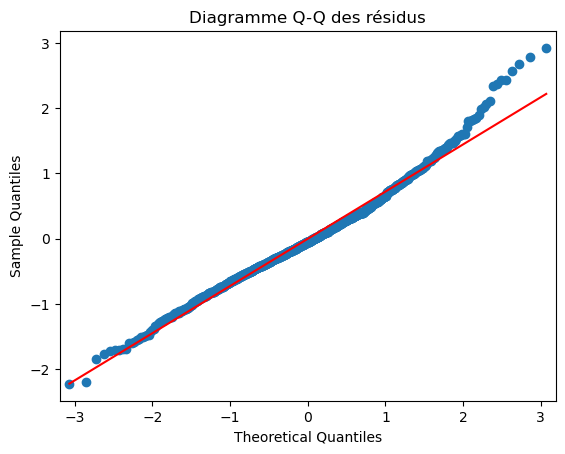


Test de Shapiro-Wilk pour la normalité des résidus
Statistique : 0.9843, p-value : 0.0000
Conclusion : Rejet de H0, les résidus ne sont pas normalement distribués.

Statistique : 0.1060, p-value : 0.0000
Conclusion : H0 rejetée, les résidus ne suivent pas une distribution normale.

is_genuine
1    797
0    403
Name: count, dtype: int64


In [23]:
# Application du preprocessing et de l'imputation par régression au trainset
trainset_reg= trainset.copy()
X_train, y_train = preprocessing_regression_imputer(trainset_reg,target_column='margin_low')


Les performances de la régression ne sont pas satisfaisantes, d'autant plus que les hypothèses ne sont pas vérifiées, notamment celle de l'homoscédasticité.
Dans ces conditions le choix est de ne pas imputer les valeurs manquantes avec la méthode de régression mais de les supprimer. Un KNN imputer aurait sans doute été plus adapté dans notre cas.

<h2 style="font-size: 2.5em;">2. Preprocessing avec suppression des NaN</h2>
<a id="2-preprocessing-avec-suppression-des-nan"></a>

### Fonction de suppression des Nan

In [24]:
def clean_and_split(df):
    
    # Supprimer les lignes contenant des valeurs NaN
    df_cleaned = df.dropna()
    
    return df_cleaned
    

### Fonction de preprocessing avec suppression des Nan

In [25]:
def preprocessing (df,target_column):
    # Étape 1: Encodage
    df = encodage(df)
    # Étape 2: Suppression des Nan et split
    df= clean_and_split(df)
    
# Séparer les caractéristiques et la variable cible 
    X = df.drop('is_genuine', axis=1)
    y = df['is_genuine']

    return  X, y

In [26]:
# Preprocessing sur trainset et testset
X_train, y_train = preprocessing(trainset,target_column='margin_low')
X_test, y_test = preprocessing(testset,target_column='margin_low')

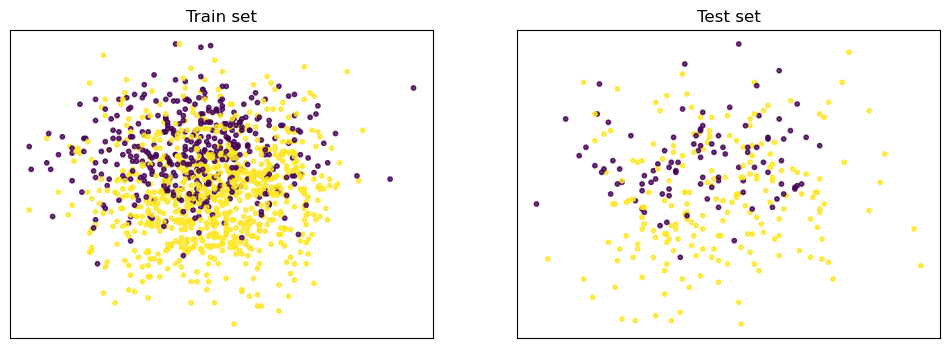

In [27]:
# Visualisation des deux splits
plt.figure(figsize=(12, 4))

# Pour le jeu d'entraînement
plt.subplot(121)
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], s=10, c=y_train, alpha=0.8)
plt.title('Train set')
plt.xticks([])  
plt.yticks([])
# Pour le jeu de test
plt.subplot(122)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1],s=10, c=y_test, alpha=0.8)
plt.title('Test set')
plt.xticks([])  
plt.yticks([])
plt.show()


<h2 style="font-size: 2.5em;">3. Polynomial Transformation and Features Selection</h2>
<a id="3-polynomial-transformation-and-features-selection"></a>

Dans cette étape, nous appliquons une transformation polynomiale à nos caractéristiques d'origine pour enrichir le dataset et capturer les relations non linéaire dans nos données.

Ensuite, nous procéderons à la sélection des caractéristiques les plus pertinentes avant de comparer à la prochaine étapes différents modèles sur ce dataset amélioré.

### Fonction d'évaluation de la performance des modèles

In [28]:
def evaluation(model):
    # Ajustement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur le jeu de test
    ypred = model.predict(X_test)
    
    # Matrice de confusion et rapport de classification
    print("Matrice de confusion :")
    print(confusion_matrix(y_test, ypred))
    print("\nRapport de classification :")
    print(classification_report(y_test, ypred))
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"\nScores de validation croisée : {cv_scores}")
    print(f"F1 Score moyen de validation croisée : {np.mean(cv_scores)}")
    
    
    # Courbes d'apprentissage
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=5, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.title('Courbe d\'apprentissage')
    plt.xlabel('Taille de l\'échantillon d\'entraînement')
    plt.ylabel('Score F1')
    plt.legend()
    plt.show()

### Fonction d'évaluation de l'importance des variables

In [29]:
def evaluer_importance_caracteristiques(X_train, y_train, degre_poly=2, model=None, seuil=0.01):
   
    # Étape 1 : Appliquer PolynomialFeatures
    poly = PolynomialFeatures(degre_poly, include_bias=False)
    X_poly_train = poly.fit_transform(X_train)

    # Étape 2 : Entraîner le modèle si aucun modèle n'est spécifié, utiliser RandomForestClassifier par défaut
    if model is None:
        model = RandomForestClassifier(random_state=0)

    model.fit(X_poly_train, y_train)

    # Étape 3 : Obtenir les importances des caractéristiques
    importances = model.feature_importances_

    # Étape 4 : Obtenir les noms des caractéristiques après transformation
    feature_names = poly.get_feature_names_out(X_train.columns)

    # Étape 5 : Créer un DataFrame pour les importances des caractéristiques
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Étape 6 : Trier le DataFrame par importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Étape 7 : Visualiser les importances
    importance_df.plot.bar(x='Feature', y='Importance', title='Importance des Caractéristiques', legend=False)
    plt.show()

    # Filtrer les variables selon le seuil
    variables_interessantes = importance_df[importance_df['Importance'] > seuil]

    # Obtenir le nombre de variables intéressantes
    nombre_variables_interessantes = variables_interessantes.shape[0]

    # Afficher le nombre de variables intéressantes
    print(f"Nombre de variables intéressantes : {nombre_variables_interessantes}")

On va evaluer un modèle de random forest, à la fois robuste et simple selon plusieurs configurations de variables, en testant des transformations polynomiales de degré 2 et 3, en plus des variables d'origines

In [30]:
model_1= RandomForestClassifier(min_samples_leaf=5,random_state=0)

Matrice de confusion :
[[ 96   1]
 [  0 199]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296


Scores de validation croisée : [1.         0.9903537  0.9903537  0.98701299 0.99350649]
F1 Score moyen de validation croisée : 0.9922453752035745


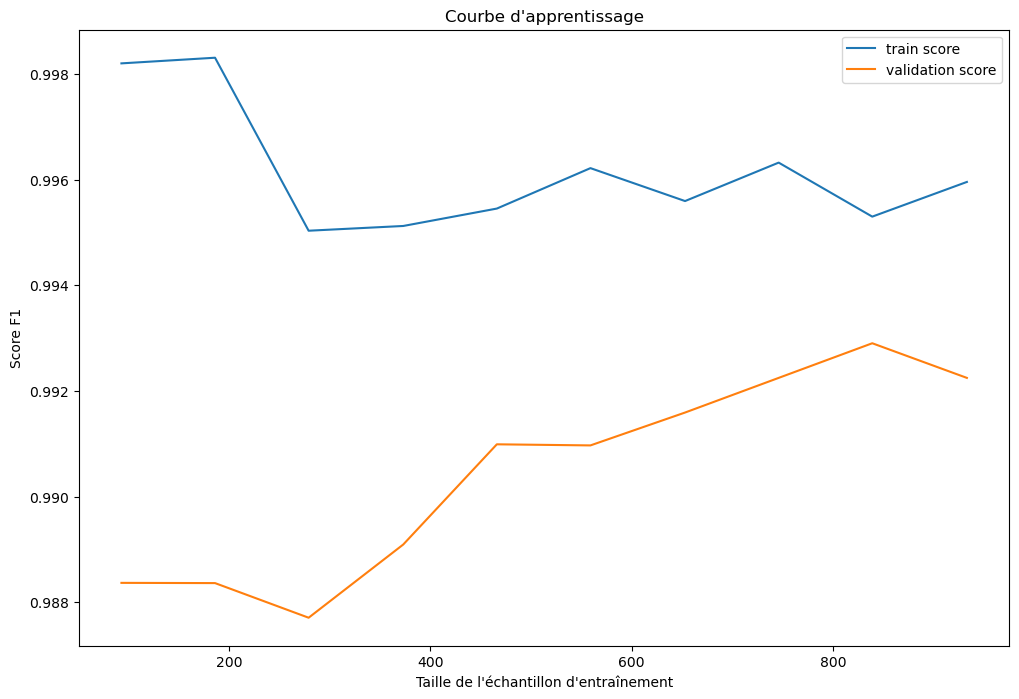

In [31]:

evaluation(model_1)

<Axes: >

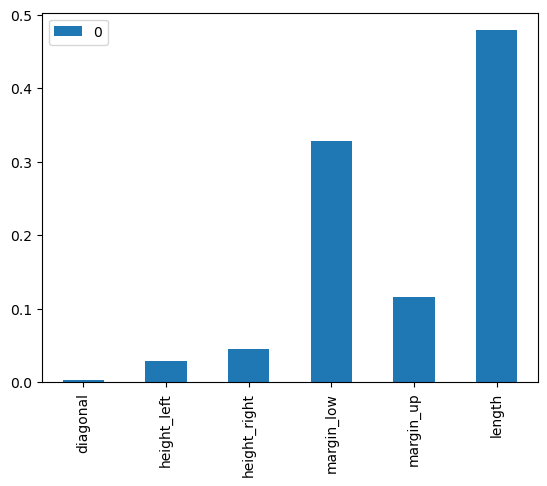

In [32]:
# Recherches des meilleurs variables
pd.DataFrame(model_1.feature_importances_, index= X_train.columns).plot.bar()

In [33]:
model_1= make_pipeline(SelectKBest(f_classif, k=3),RandomForestClassifier(min_samples_leaf=5,random_state=0))

Matrice de confusion :
[[ 97   0]
 [  2 197]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        97
           1       1.00      0.99      0.99       199

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296


Scores de validation croisée : [1.         0.98709677 0.9903537  0.99022801 0.99350649]
F1 Score moyen de validation croisée : 0.9922369956957109


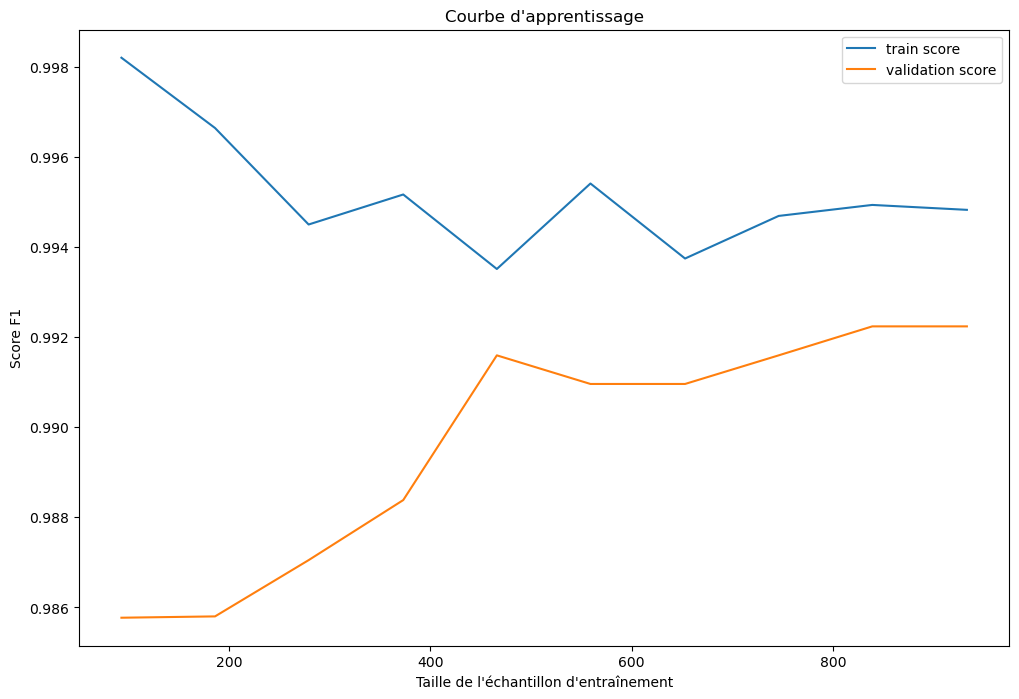

In [34]:
evaluation(model_1)

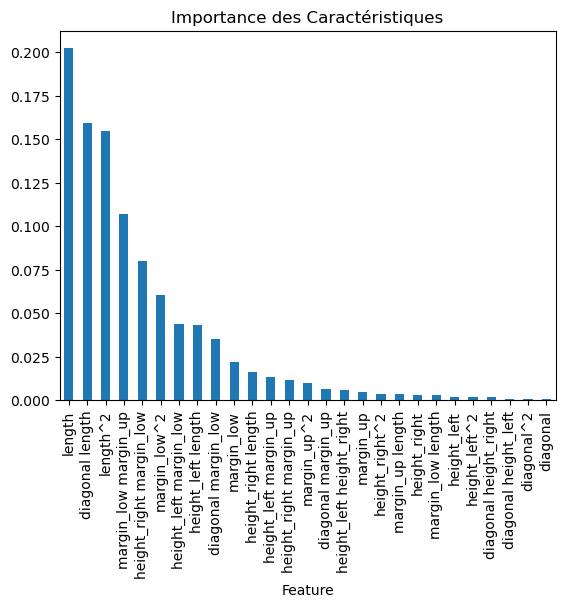

Nombre de variables intéressantes : 14


In [35]:
# Classer les caractéristiques après PolynomialFeatures=2
evaluer_importance_caracteristiques(X_train, y_train, degre_poly=2, seuil= 0.01)

In [36]:
model_2= make_pipeline(PolynomialFeatures(2,include_bias=False),SelectKBest(f_classif, k=10),RandomForestClassifier(min_samples_leaf=5,random_state=0))

Matrice de confusion :
[[ 97   0]
 [  0 199]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      1.00      1.00       296
weighted avg       1.00      1.00      1.00       296


Scores de validation croisée : [1.         0.98717949 0.98717949 0.98701299 0.99350649]
F1 Score moyen de validation croisée : 0.9909756909756909


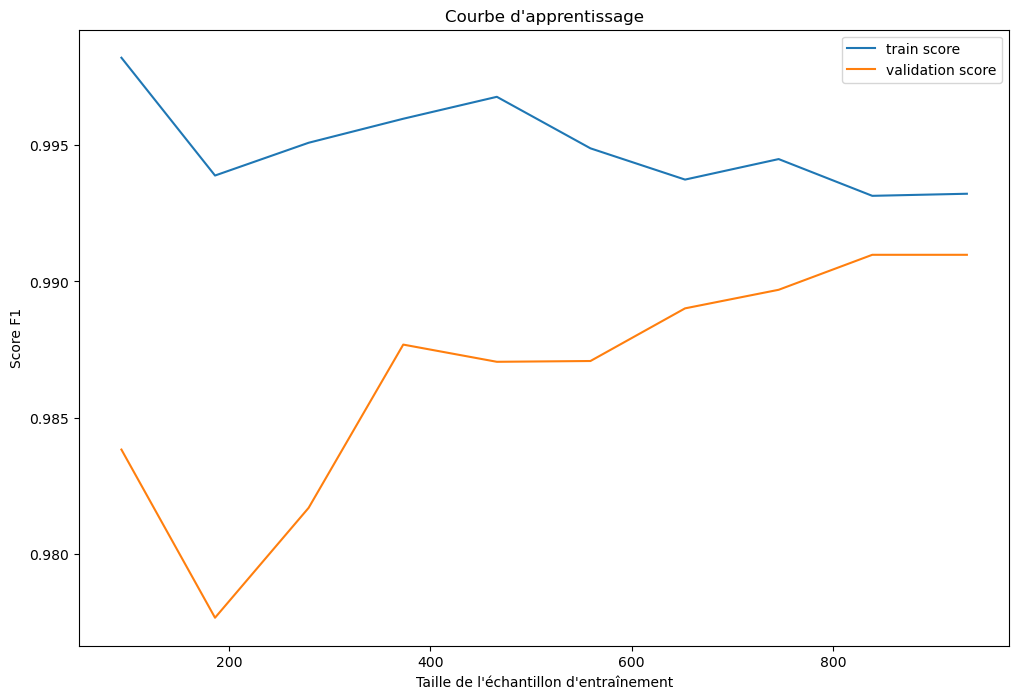

In [37]:
evaluation(model_2)

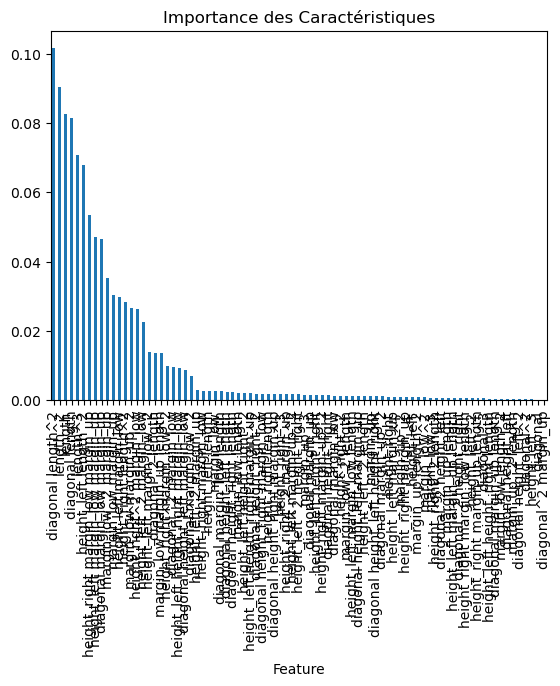

Nombre de variables intéressantes : 19


In [38]:
# Classer les caractéristiques après PolynomialFeatures=3
evaluer_importance_caracteristiques(X_train, y_train, degre_poly=3, seuil=0.01)

In [39]:
model_3= make_pipeline(PolynomialFeatures(3,include_bias=False),SelectKBest(f_classif, k=16),RandomForestClassifier(min_samples_leaf=5,random_state=0))

Matrice de confusion :
[[ 97   0]
 [  3 196]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        97
           1       1.00      0.98      0.99       199

    accuracy                           0.99       296
   macro avg       0.98      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296


Scores de validation croisée : [1.         0.98392283 0.98717949 0.99350649 0.98371336]
F1 Score moyen de validation croisée : 0.9896644330633668


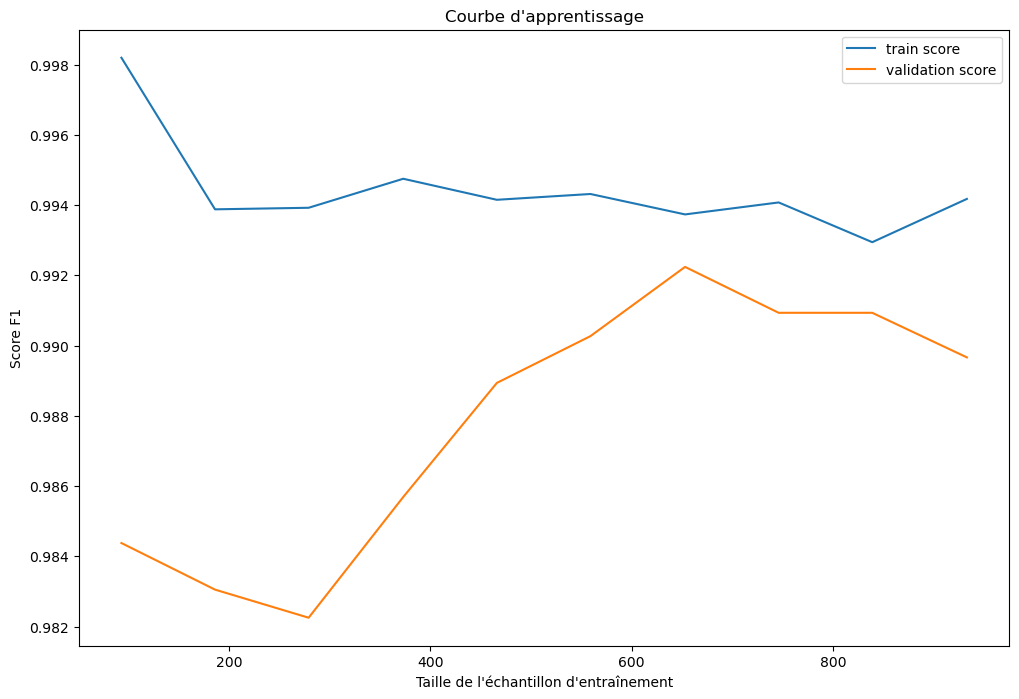

In [40]:
evaluation(model_3)

On constate qu'une transformation polynomial de degré 2, suivie d'une sélection des 10 variables les plus significatives, permettait d'obtenir de meilleurs résultats avec notre modèle. Nous allons donc utiliser cette configuration pour tester différents modèles.

<h1 style="font-size: 3em;">Modélisation</h1>
<a id="modélisation"></a>

In [41]:
# Définition du pipeline de prétraitement
preprocessor =  make_pipeline(PolynomialFeatures(2,include_bias=False),SelectKBest(f_classif, k=10))

<h2 style="font-size: 2.5em;">1. Modèle d'apprentissage non supervisé - KMeans</h2>
<a id="1-modèle-dapprentissage-non-supervisé---kmeans"></a>

<h3 style="font-size: 2em;">Analyse en composante principale</h3>
<a id="analyse-en-composante-principale"></a>

In [42]:
pca = make_pipeline(preprocessor.set_params(selectkbest__k=15),StandardScaler(),PCA(n_components=3))

In [43]:
# entraîner
pca.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=15))])),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3))])

In [44]:
# Accéder à l'objet PCA dans le pipeline
pca_obj = pca.named_steps['pca']

# Variance de chaque composant
variance_expliquee = pca_obj.explained_variance_

# Créer un DataFrame pour visualiser la variance expliquée
main_vars_variance = pd.DataFrame({
    'Composant Principal': [f'PC{i+1}' for i in range(len(variance_expliquee))],
    'Variance Expliquée': variance_expliquee
})
main_vars_variance

Composant Principal  Variance Expliquée
0                 PC1           10.810604
1                 PC2            2.224694
2                 PC3            1.710328

In [45]:
# variance expliquée en %
scree = (pca_obj.explained_variance_ratio_*100).round(2)
# faire la somme cumulée des ratios
scree_cum = scree.cumsum().round()

print(scree)
print(scree_cum)

[72.01 14.82 11.39]
[72. 87. 98.]


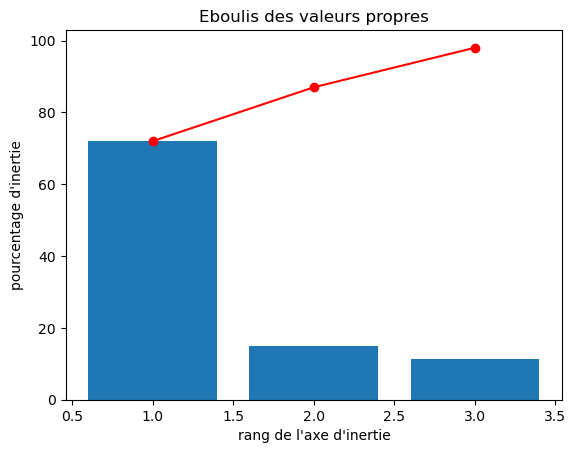

In [46]:
# tracer le graphique des éboulis propres
x_list = range(1, 4)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.savefig('Eboulis des valeurs propres.png')
plt.show(block=False)

On constate un coude marqué au niveau du 3ème rang, on choisit donc de conserver 3 composants.

<h3 style="font-size: 2em;">Clustering avec KMeans</h3>
<a id="clustering-avec-kmeans"></a>

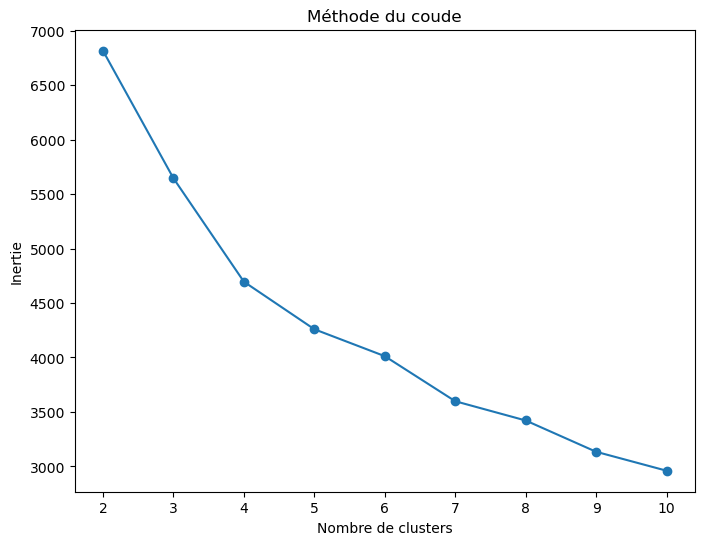

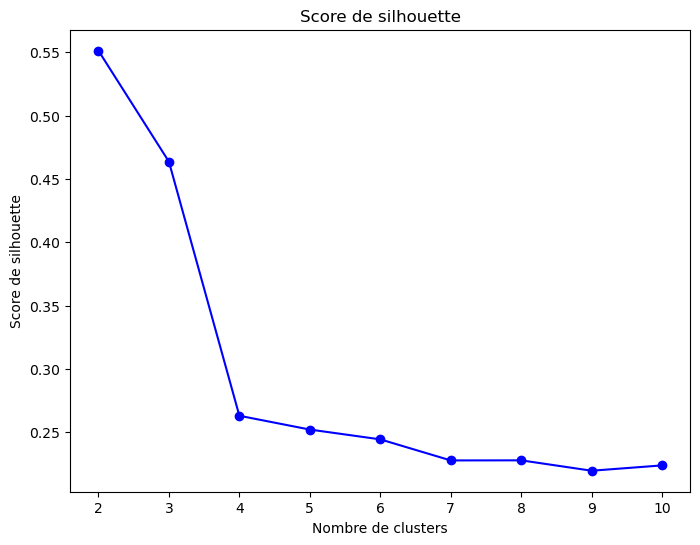

In [47]:
# Appliquer le pipeline sur X_train 
X_train_pca = pca.transform(X_train)

# 1. Méthode du coude et score de silhouette déterminer le nombre optimal de clusters
inertia = []  # Liste pour stocker les inerties
silhouette_scores = []
k_range = range(2, 11)  # Tester de 2 à 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_train_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Tracer la méthode du coude
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid(False)
plt.show()

# Tracer le score de silhouette
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', color='blue')
plt.title('Score de silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.grid(False)
plt.show()

La méthode du coude montre une réduction marquée de l'inertie avec un nombre de clusters faible, ce qui indique un bon point de coupure aux alentours de 2 ou 3 clusters.
Le score de silhouette montre un maximum clair pour 2 clusters et une baisse notable à partir de ce point, ce qui en fait le choix optimal.
Opter pour 2 clusters semble judicieux, tant du point de vue des résultats de clustering que de la nature des données (vrai vs faux billets).

In [48]:
# Appliquer le pipeline sur X_test
X_test_pca = pca.transform(X_test)
# Appliquer KMeans avec 2 clusters sur les données PCA
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(X_train_pca)

# Prédire les clusters sur le jeu de test avec kmeans
ypred = kmeans.predict(X_test_pca)

# Vérifier la répartition des classes et inverser les labels si nécessaire
if y_test is not None:
    # Compter les vrais positifs et faux positifs
    true_positives = np.sum((ypred == 1) & (y_test == 1))
    false_positives = np.sum((ypred == 1) & (y_test == 0))
    
    # Inverser les labels si le cluster 1 a plus de faux positifs que de vrais positifs
    if false_positives > true_positives:
        ypred = np.where(ypred == 1, 0, 1)

    # Afficher la confusion matrix et le classification report
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))


[[ 93   4]
 [  0 199]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        97
           1       0.98      1.00      0.99       199

    accuracy                           0.99       296
   macro avg       0.99      0.98      0.98       296
weighted avg       0.99      0.99      0.99       296



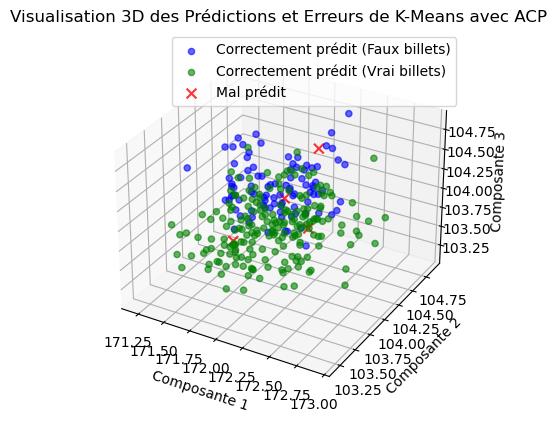

In [49]:
# Créer la figure et un graphique 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Identifier les points mal prédits
misclassified = (ypred != y_test)

# Couleurs pour les points correctement prédits
# Points correctement prédits du cluster 0
correct_cluster_0 = (ypred == 0) & (~misclassified)

# Points correctement prédits du cluster 1
correct_cluster_1 = (ypred == 1) & (~misclassified)

# Afficher les points correctement prédit du cluster 0
ax.scatter(X_test[correct_cluster_0].iloc[:, 0], X_test[correct_cluster_0].iloc[:, 1], X_test[correct_cluster_0].iloc[:, 2], 
           c='blue', label='Correctement prédit (Faux billets)', s=20, alpha=0.6)

# Afficher les points correctement prédit du cluster 1
ax.scatter(X_test[correct_cluster_1].iloc[:, 0], X_test[correct_cluster_1].iloc[:, 1], X_test[correct_cluster_1].iloc[:, 2], 
           c='green', label='Correctement prédit (Vrai billets)', s=20, alpha=0.6)

# Afficher les points mal prédit
ax.scatter(X_test[misclassified].iloc[:, 0], X_test[misclassified].iloc[:, 1], X_test[misclassified].iloc[:, 2], 
           c='red', label='Mal prédit', s=50, alpha=0.8, marker='x')

# Ajouter des labels et une légende
ax.set_xlabel('Composante 1')
ax.set_ylabel('Composante 2')
ax.set_zlabel('Composante 3')
plt.legend()
plt.title('Visualisation 3D des Prédictions et Erreurs de K-Means avec ACP')

plt.show()

<h2 style="font-size: 2.5em;">2. Modèles d'apprentissage supervisés</h2>
<a id="2-modèles-dapprentissage-supervisés"></a>

Nous choisissons de tester ici 5 différents modèles, avec les réglages que nous avions optimiser à l'issue de la phase de préprocessing. Pour cela nous allons les soumettre à la même procédure d'évaluation définie aussi à la phase précédente.
Les étepes sont les suivantes:
1) Entrainer et évaluer une liste de modeles avec les reglages de base
2) Retenir les 2-3 modeles avec le meilleur score de test, en privilégiant les situations de non-overfitting
3) Optimiser les hyper-parametres de ces modeles avec un tour GridSearchCV, puis un tour RandomizedSearchCV
4) régler un threshold pour obtenir le recall ou la précision désiré

Les modèles choisis fonctionnent de différentes manières, avec un modèle de bagging (RandomForestClassifier), un modèle de boosting (AdaBoostClassifier), de régression (LogisticRegression), un modèle de SVM(SVC) et un modèle un peu plus basique (KNN).

In [50]:
# Définir les pipelines de classification
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(min_samples_leaf=5,random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(algorithm='SAMME',random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(probability=True,random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())
Logistic = make_pipeline(preprocessor, StandardScaler(), LogisticRegression(random_state=0))

In [51]:
# Etablir un dictionnaire de modèles
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN,
                  'Logistic':Logistic                 
                 }

## Procédure d'évaluation

RandomForest
Matrice de confusion :
[[ 96   1]
 [  0 199]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296


Scores de validation croisée : [1.         0.98717949 0.98717949 0.99029126 0.99350649]
F1 Score moyen de validation croisée : 0.9916313460002781


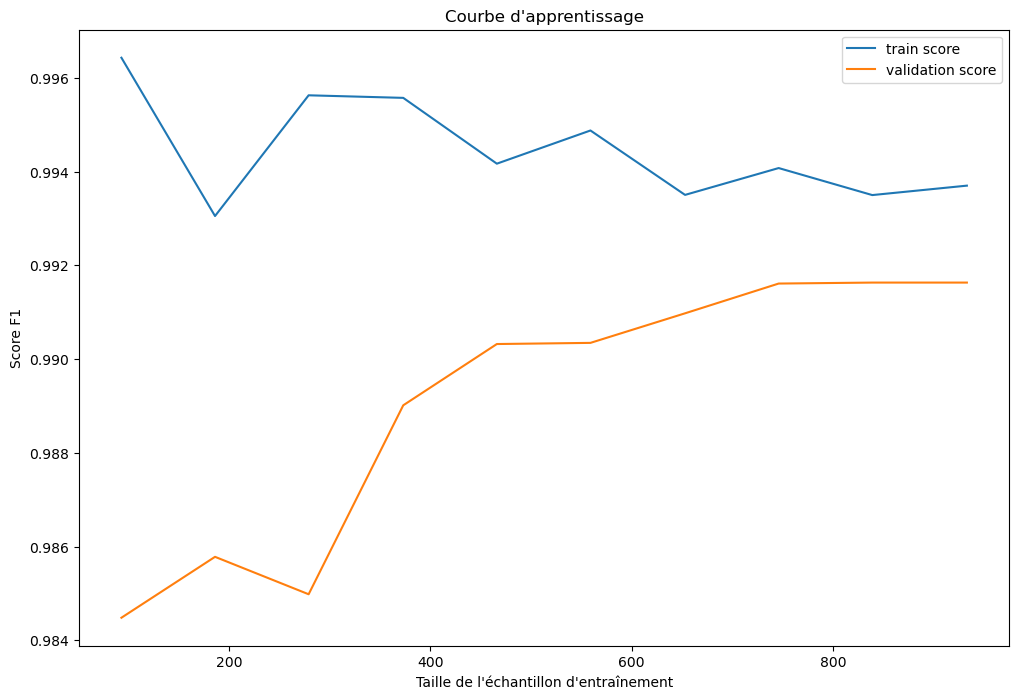

AdaBoost
Matrice de confusion :
[[ 96   1]
 [  3 196]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        97
           1       0.99      0.98      0.99       199

    accuracy                           0.99       296
   macro avg       0.98      0.99      0.98       296
weighted avg       0.99      0.99      0.99       296


Scores de validation croisée : [0.99678457 0.98381877 0.98717949 0.99676375 0.99350649]
F1 Score moyen de validation croisée : 0.9916106141748449


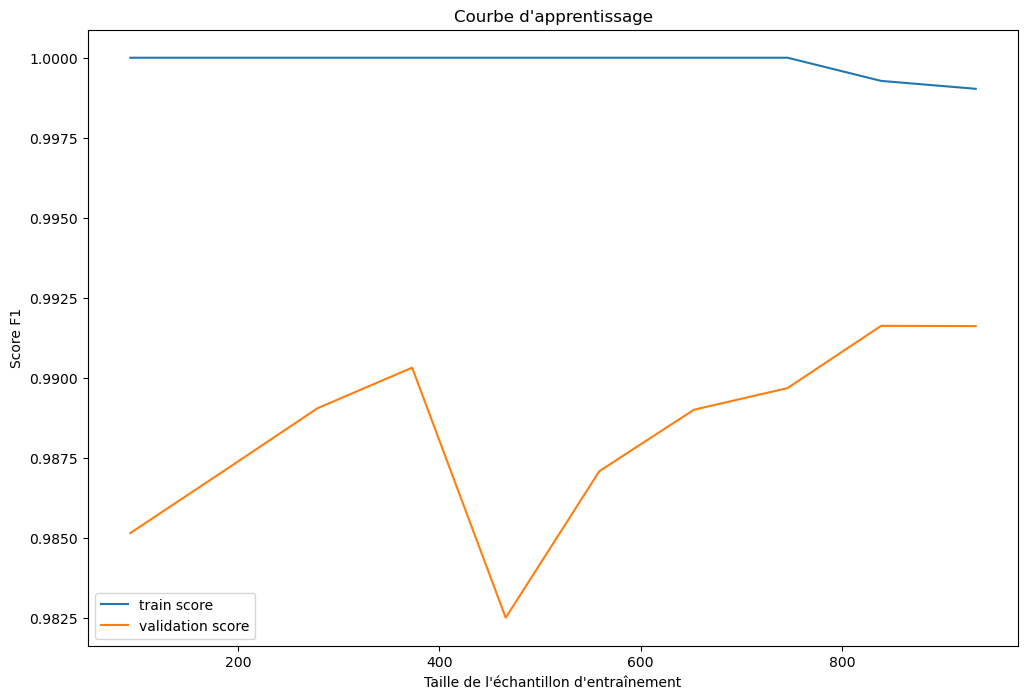

SVM
Matrice de confusion :
[[ 96   1]
 [  2 197]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        97
           1       0.99      0.99      0.99       199

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296


Scores de validation croisée : [1.         0.98709677 0.9903537  0.99676375 0.99029126]
F1 Score moyen de validation croisée : 0.9929010976247948


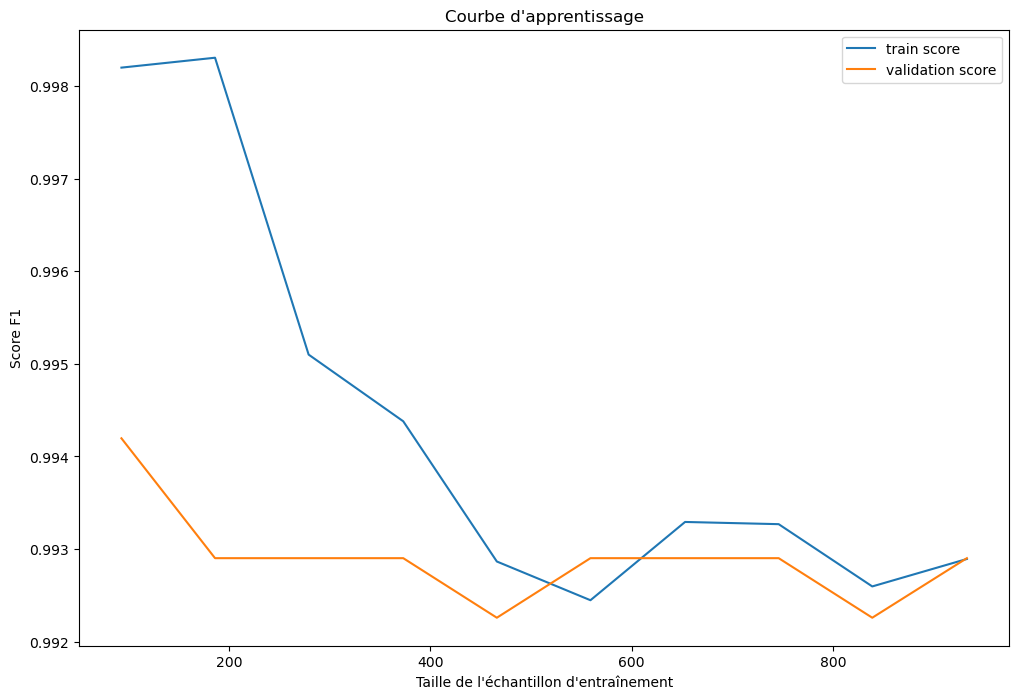

KNN
Matrice de confusion :
[[ 96   1]
 [  2 197]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        97
           1       0.99      0.99      0.99       199

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296


Scores de validation croisée : [1.         0.98709677 0.98717949 0.99354839 0.99029126]
F1 Score moyen de validation croisée : 0.9916231821211465


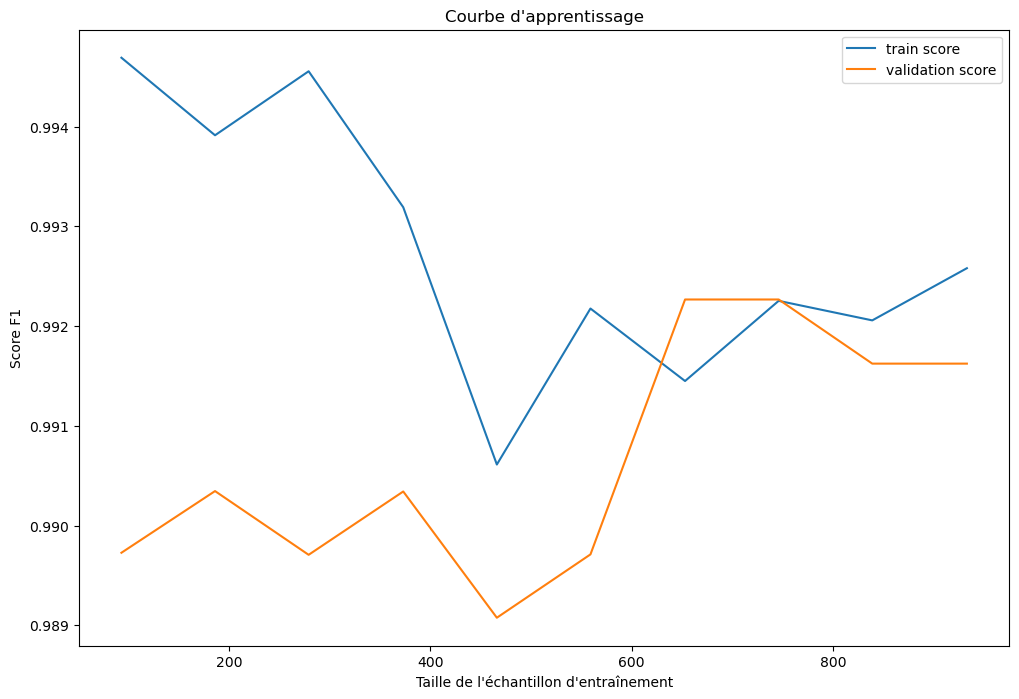

Logistic
Matrice de confusion :
[[ 96   1]
 [  0 199]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296


Scores de validation croisée : [0.99678457 0.99354839 0.9903537  0.99676375 0.98701299]
F1 Score moyen de validation croisée : 0.9928926783641326


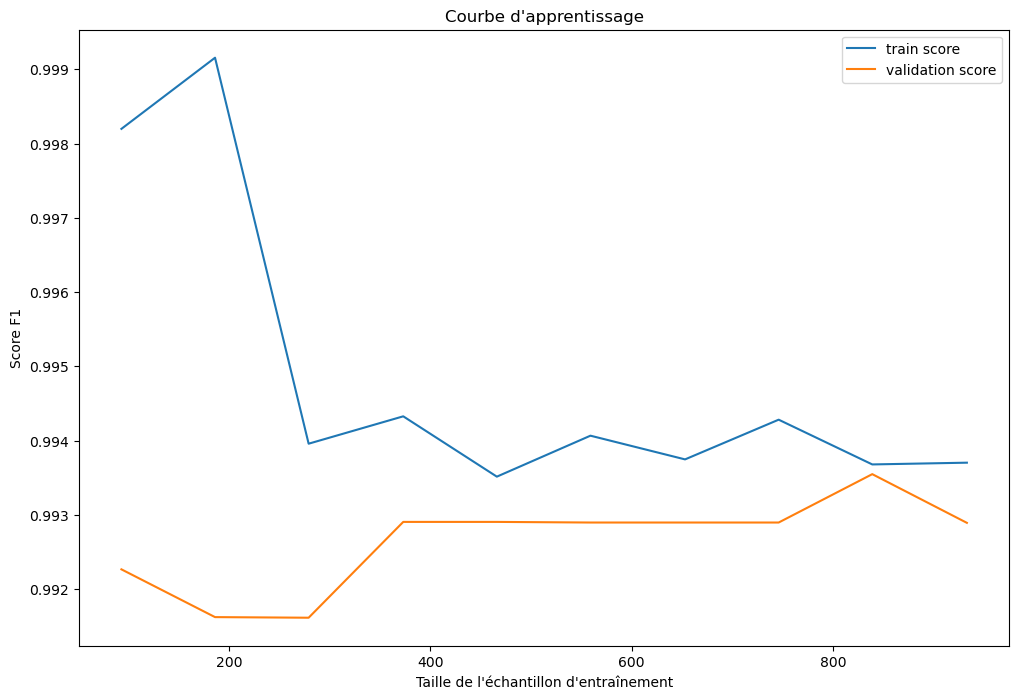

In [52]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

Les scores sont très proches entre les différents modèles, nous choisissons de continuer avec SVM qui fournit souvent de très bon résultats sur les dataset de petites et moyennes tailles et logisticregression qui était un des modèles suggérés dans le cahiers des charges, et qui obtient les meilleurs résultats. 
AdaBoost est prometteur mais il est plus pointu à paramétrer et il est préférable de se tourner vers des modèles plus simples quand ils donnent déjà de bon résultats

<h2 style="font-size: 2.5em;">3. Optimisation des modèles sélectionnés</h2>
<a id="3-optimisation-des-modèles-sélectionnés"></a>


<h3 style="font-size: 2em;">Modèle SVM</h3>
<a id="modèle-svm"></a>

In [53]:
# Pipeline du modèle
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=15))])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True, random_state=0))])

In [54]:
# Définition des hyperparamètres à tester
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2,3],
               'pipeline__selectkbest__k': range(4, 75)}

In [55]:
# Recherche des meilleurs hyperparamètres
grid_svm = RandomizedSearchCV(SVM, hyper_params, scoring='f1', cv=4,
                          n_iter=100)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)
print(grid_svm.best_score_)
y_pred = grid_svm.predict(X_test)

print(classification_report(y_test, y_pred))

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 57, 'pipeline__polynomialfeatures__degree': 3}
0.9948485622904227
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296



Matrice de confusion :
[[ 96   1]
 [  0 199]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296


Scores de validation croisée : [0.99678457 0.9903537  0.9903537  0.99022801 0.99350649]
F1 Score moyen de validation croisée : 0.9922452935901201


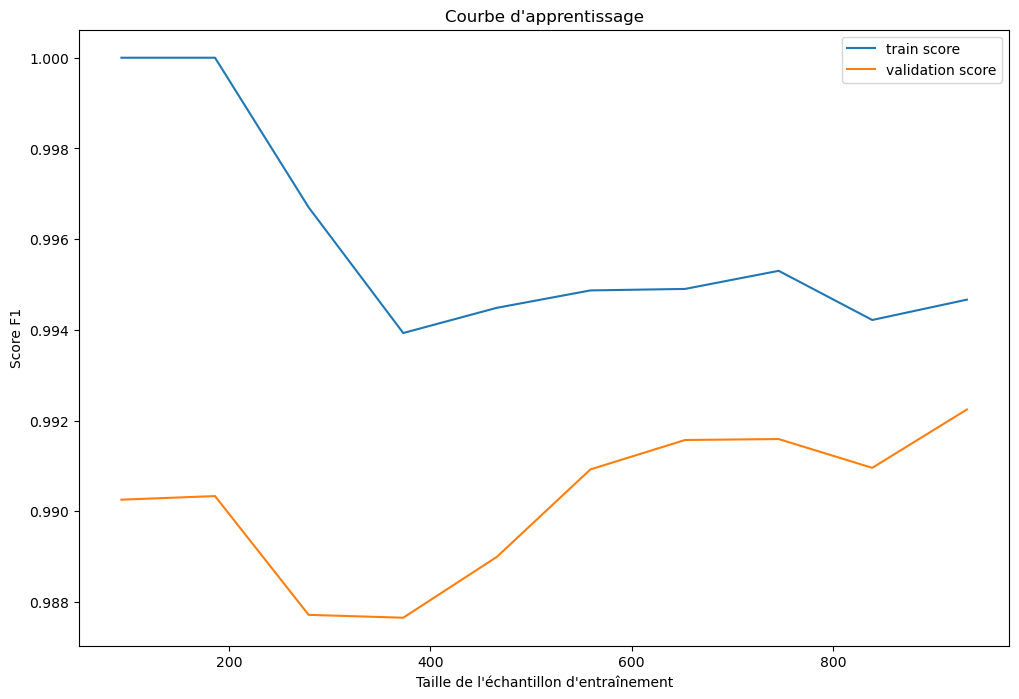

In [56]:
# Evaluation du meilleur estimateur
evaluation(grid_svm.best_estimator_)

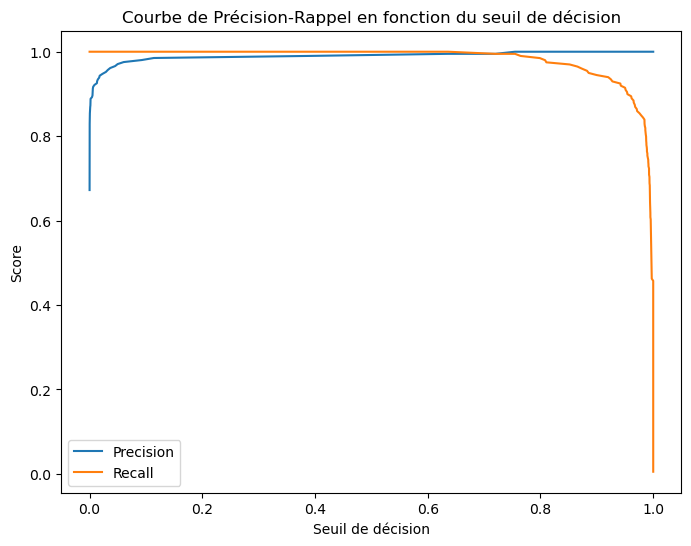

In [57]:
# Calcul des probabilités pour la classe 1 (classe des vrais billets)
y_pred_prob_svm = grid_svm.best_estimator_.predict_proba(X_test)[:, 1]  

# Calcul des courbes de précision et rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_svm)

# Affichage de la courbe de précision et rappel en fonction des seuils
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.title('Courbe de Précision-Rappel en fonction du seuil de décision')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Histogramme des probabilités')

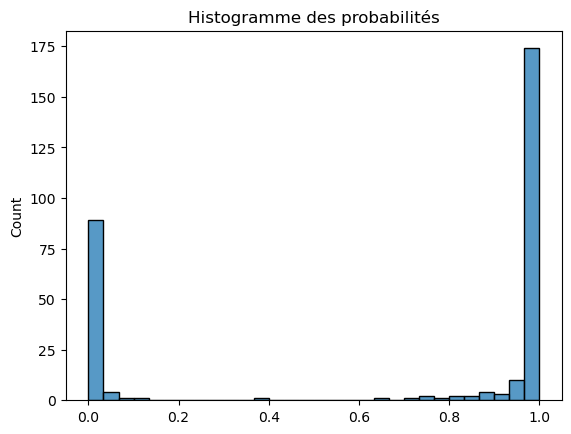

In [58]:
# Afficher l'histogramme des probabilités
sns.histplot(y_pred_prob_svm, bins=30)
plt.title('Histogramme des probabilités')

Le modèle est assez fiable dans ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

### Fonction du modèle final SVM avec le seuil de décision optimal

In [59]:
def model_SVM_final(model, X, threshold=0.5):
    return model.decision_function(X) > threshold

In [60]:
# Score f1 du modèle sur le testset pour la classe 0
best_svm_model = grid_svm.best_estimator_
y_pred = model_SVM_final(best_svm_model, X_test, threshold=0.65)
precision_score(y_test, y_pred,pos_label=0)

0.97

In [61]:
# Score de recall du modèle sur le testset pour la classe 0
recall_score(y_test, y_pred,pos_label=0)

1.0

In [62]:
# Sauvegarde du modèle
joblib.dump(best_svm_model, 'final_SVM_model.pkl')


['final_SVM_model.pkl']

<h3 style="font-size: 2em;">Modèle de régression logistique</h3>
<a id="modèle-de-régression-logistique"></a>


In [63]:
# Pipeline du modèle
Logistic

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=15))])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

In [64]:
# Définition des hyperparamètres à tester
hyper_params_logistic = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],      # Types de régularisation
                'logisticregression__C': [0.01, 0.1, 1, 10, 100],                       # Force de la régularisation
               'logisticregression__solver': ['saga', 'liblinear', 'lbfgs']  , 
               'pipeline__polynomialfeatures__degree':[2,3],
               'pipeline__selectkbest__k': range(25, 60)}

In [65]:
# Recherche des meilleurs hyperparamètres
grid_logistic = RandomizedSearchCV(Logistic, hyper_params_logistic, scoring='f1', cv=4,
                          n_iter=100)

grid_logistic.fit(X_train, y_train)

print(grid_logistic.best_params_)
print(grid_logistic.best_score_)
y_pred = grid_logistic.predict(X_test)

print("Matrice de confusion :")
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, y_pred))

{'pipeline__selectkbest__k': 33, 'pipeline__polynomialfeatures__degree': 2, 'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 0.1}
0.9935697477700196
Matrice de confusion :
[[ 93   4]
 [  0 199]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296



Matrice de confusion :
[[ 96   1]
 [  0 199]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.99      1.00      1.00       199

    accuracy                           1.00       296
   macro avg       1.00      0.99      1.00       296
weighted avg       1.00      1.00      1.00       296


Scores de validation croisée : [0.99678457 0.98381877 0.9903537  0.99676375 0.99350649]
F1 Score moyen de validation croisée : 0.9922454562887866


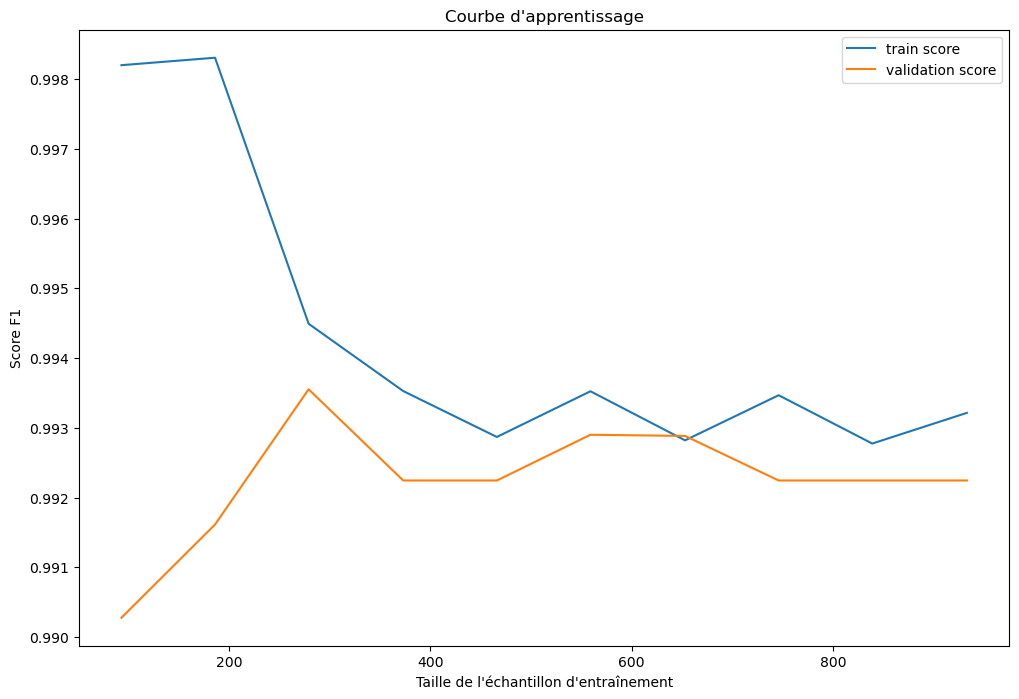

In [66]:
# Evaluation du meilleur estimateur
evaluation(grid_logistic.best_estimator_)

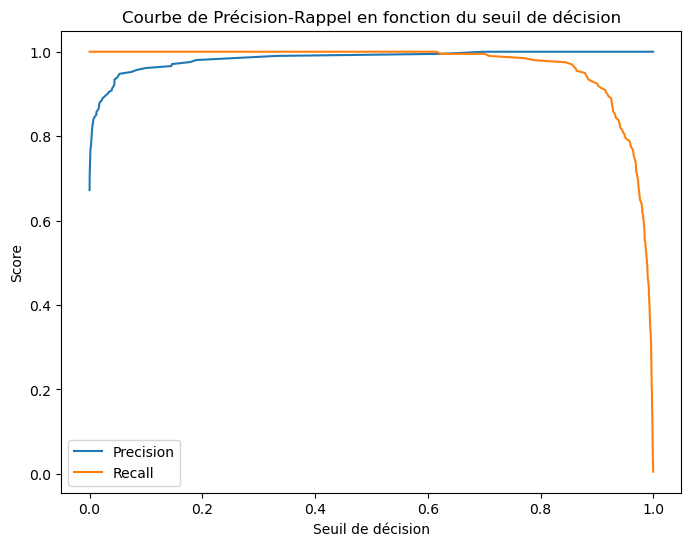

In [67]:
# Calcul des probabilités pour la classe 1 (classe des vrais billets)
y_pred_prob = grid_logistic.best_estimator_.predict_proba(X_test)[:, 1]  

# Calcul des courbes de précision et rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Affichage de la courbe de précision et rappel en fonction des seuils
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.title('Courbe de Précision-Rappel en fonction du seuil de décision')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Histogramme des probabilités')

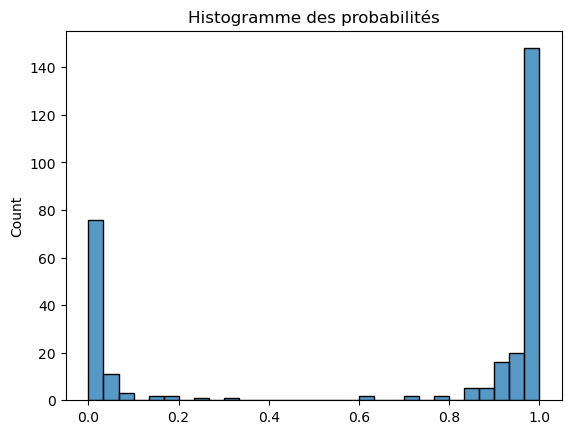

In [68]:
# Afficher l'histogramme des probabilités
sns.histplot(y_pred_prob, bins=30)
plt.title('Histogramme des probabilités')

Le modèle est assez fiable dans ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

### Fonction du modèle final logistic regression avec le seuil de décision optimal

In [69]:
def model_logistic_final(model, X, threshold=0.5):
    return model.decision_function(X) > threshold

In [70]:
# Score f1 du modèle sur le testset pour la classe 0
best_logistic_model = grid_logistic.best_estimator_
y_pred = model_logistic_final(best_logistic_model, X_test, threshold=0.6)
precision_score(y_test, y_pred, pos_label=0)

0.9897959183673469

In [71]:
# Score de recall du modèle sur le testset pour la classe 0
recall_score(y_test, y_pred,pos_label=0)

1.0

In [72]:
# Sauvegarde du modèle
joblib.dump(best_logistic_model, 'final_logistic_model.pkl')

['final_logistic_model.pkl']

<h1 style="font-size: 3em;">Conclusion</h1>
<a id="conclusion"></a>

Après avoir préparé notre dataset, sélectionné les modèles les plus performant et les avoir optimisé, nous obtenons deux modèles à la fois robustes est performants dans la détection de faux billets. 

Le score de recall presque parfait montre la capacité de nos modèles à ne laisser passer aucun faux billet, tout en restant fiable pour ne pas classer des vrais billets comme faux (précision). Les objectifs fixés dans l'introduction sont donc atteints.

Les deux modèles sont chargés est prêt à être utilisé dans un notebook nommé 'Application détection faux billets'.